In [ ]:
# using an open library that preimplemented rubik-cube states

!pip install rubik-cube
from rubik.cube import Cube
import numpy as np
import tensorflow as tf
from tensorflow import keras
from random import randint
import random
import copy


In [ ]:
# PROBLEM_SIZE defines the maximum number of random twists given to th cube. 
# The size of the label encoding and the perfomance of the network are dependent on it.
PROBLEM_SIZE = 5


# scrambling function. Generates a randomly scrambled cube and returns it in a tuple together with the number of twists given to it
def scramble(length=None):
  c = Cube("OOOOOOOOOYYYWWWGGGBBBYYYWWWGGGBBBYYYWWWGGGBBBRRRRRRRRR")
  if length == None:
    length = randint(0, PROBLEM_SIZE)
  last_move = None
  for i in range(length):
    move = randint(0,12)
    if move == last_move:
      r = [i in range(0,last_move)] + [i in range(last_move + 1, 12)]
      move = random.choice(r)
    last_move = move
    if move == 0:
      c.R()
    elif move == 1:
      c.Ri()
    elif move == 2:
      c.L()
    elif move == 3:
      c.Li()
    elif move == 4:
      c.U()
    elif move == 5:
      c.Ui()
    elif move == 6:
      c.B()
    elif move == 7:
      c.Bi()
    elif move == 8:
      c.D()
    elif move == 9:
      c.Di()
    elif move == 10:
      c.F()
    else:
      c.Fi()
    # returning the scrambled cube + how far away it is from the solved state
  return c, length


def scramble_to_number():
  for i in range(100000):
    c, l = scramble()

    yield tf.constant(to_num_format(c)), tf.constant(tf.one_hot(l, PROBLEM_SIZE+1))

def to_format(c):
  string = str(c)
  string = string.replace(" ","").replace("\n", "")
  return string


def to_num_format(c):
  dict = {'O': 1,'B': 2,'Y': 3,'W': 4,'R': 5,'G': 6}
  string = to_format(c)
  charlist = list(string)
  numlist = [dict[x] for x in charlist]
  return numlist



In [ ]:
scramble()

(<rubik.cube.Cube at 0x7efc00cc20d0>, 2)

In [ ]:
ds = tf.data.Dataset.from_generator(scramble_to_number,
                                    output_signature=(
                                        (tf.TensorSpec((54,), dtype=tf.int8),
                                         tf.TensorSpec(shape=(PROBLEM_SIZE+1,), dtype=tf.int8))
                                        )
                                    )
ds = ds.batch(256)


In [ ]:
for i in range(0,0):
  print(i)

In [ ]:
# simple neural network that learns the guidance function 

from keras import Model
class LGF(Model):
  def __init__(self): 
    super(LGF, self).__init__()

    self.layer_list = [keras.layers.InputLayer(input_shape=(54)),
                       keras.layers.Dense(9*6, activation=tf.keras.activations.tanh), 
                       keras.layers.Dense(2*9*6, activation=tf.keras.activations.relu), 
                       keras.layers.Dense(2*9*6, activation=tf.keras.activations.relu), 
                       keras.layers.Dropout(0.3), 
                       keras.layers.Dense(9*6, activation=tf.keras.activations.relu), 
                       keras.layers.Dense(PROBLEM_SIZE+1, activation='softmax')]


  def call(self, x): 
    for layer in self.layer_list: 
      x = layer(x)
    
    return x 


# optimizer & loss as in paper
# future work should apply meta-learning of parameters and network shape

tf.keras.backend.clear_session()
lgf = LGF()
lgf.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics='acc')



In [ ]:
lgf.fit(ds, epochs=50)

Epoch 1/50
391/391 [==============================] - 132s 336ms/step - loss: 1.1281 - acc: 0.5324
Epoch 2/50
391/391 [==============================] - 146s 373ms/step - loss: 0.6961 - acc: 0.7042
Epoch 3/50
391/391 [==============================] - 140s 359ms/step - loss: 0.6502 - acc: 0.7315
Epoch 4/50
391/391 [==============================] - 133s 340ms/step - loss: 0.6325 - acc: 0.7410
Epoch 5/50
391/391 [==============================] - 130s 332ms/step - loss: 0.6059 - acc: 0.7514
Epoch 6/50
391/391 [==============================] - 127s 324ms/step - loss: 0.5956 - acc: 0.7570
Epoch 7/50
391/391 [==============================] - 128s 328ms/step - loss: 0.5862 - acc: 0.7624
Epoch 8/50
391/391 [==============================] - 130s 334ms/step - loss: 0.5844 - acc: 0.7634
Epoch 9/50
391/391 [==============================] - 128s 328ms/step - loss: 0.5655 - acc: 0.7723
Epoch 10/50
391/391 [==============================] - 129s 330ms/step - loss: 0.5565 - acc: 0.7748
Epoch 11/

In [ ]:
# populate function receives a cube and returns an array of 12 cubes each with a different move performed on the original cube
def populate(c):
  children = [copy.deepcopy(c) for i in range(12)]
  children[0].L()
  children[1].Li()
  children[2].R()
  children[3].Ri()
  children[4].F()
  children[5].Fi()
  children[6].B()
  children[7].Bi()
  children[8].U()
  children[9].Ui()
  children[10].D()
  children[11].Di()
              
  return children


# receives a cube and returns the estimated number of moves until being solved based on the neural network
def get_score(child):
  matrix = lgf(tf.expand_dims(tf.constant(to_num_format(child)), axis=0))
  score = np.argmax(matrix)
  return score

# receives an array of cubes and generates a array of scores for each cube
def score_children(children):
  scores = [get_score(child) for child in children]
  return scores

# checks wether a given cube is solved
def check_solved(cube):
  if to_format(cube) == 'OOOOOOOOOYYYWWWGGGBBBYYYWWWGGGBBBYYYWWWGGGBBBRRRRRRRRR':

    return True
  else:
    return False


# hillclimbin algorithm receives a scrambled cube and a theta, which denotes the
# maximum number of iterations of the algorithm.
# On the basis of the neural network as a score function it tries to solve the rubics cube
def hillclimbing(cube, theta=20):
  if check_solved(cube):
    return true
  l = get_score(cube)
  for t in range(theta):

    children = populate(cube)

    for child in children:
      score = get_score(child)
      if check_solved(child):
        return True
      if score <= l:
        l = score
        cube = child
  return False
                


In [ ]:
# Tests the performance of the model. It returns the number of successfully
# solved cubes and the number of unsolved cubes by the algorithm
def test(number):
  suc = 0
  fail = 0
  for i in range(number):
    sc, _ = scramble(PROBLEM_SIZE)
    nc = hillclimbing(sc)
    if nc:
      suc += 1
    else:
      fail += 1
  print('solved: ', suc)
  print('failed: ', fail)
  return suc, fail

In [ ]:
# Run the tests
suc, fail = test(500)

solved:  295
failed:  205


Text(0.5, 1.0, 'Solved vs Failed Cubes with PS=5')

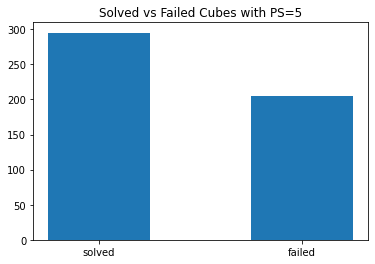

In [ ]:
# Plot the results
from matplotlib import pyplot as plt
plt.bar(x=("solved", "failed"), height=(suc, fail), width=0.5)
plt.title("Solved vs Failed Cubes with PS="+str(PROBLEM_SIZE))
